I am going to use XGBoost regressor to predict the stock returns in the following two days. It is for "the Winton Stock Market Challenge" in Kaggle competition.

I also tried using deep neural networks (DNNs), but they do not perform as good as the XGBoost regressor.

The key ideas in this work are  
(1) using XGBoost to preselect the ten most important features to fight overfitting,  
(2) using the linear loss function instead of the conventional square loss function.

The final model consistently outperforms the all-zero predict. In my test, the model also performed better than the median prediction and could rank 30th in the private leaderboard.

# Data Visualization and Feature Analysis

We load and visualize the data in the section. We also analyze the correlations between the features.

To load the zipped data, we use the zipfile package. The training data are loaded into a DataFrame in Pandas.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from zipfile import ZipFile

# zip_file = ZipFile('../input/the-winton-stock-market-challenge/train.csv.zip')
zip_file = ZipFile('train.csv.zip')
df = pd.read_csv(zip_file.open('train.csv'))
df

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-8.384789e-04,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,2.479729e-04,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,1.162100e-04,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,2.883115e-04,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,2.449409e-03,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,NaN,NaN,0.822371,NaN,1.0,2.182050,23729,0.2208,12.0,...,0.000623,0.000504,1.490012e-03,6.228587e-04,-0.000516,-0.000876,-0.024270,0.010143,1.413891e+06,1.767363e+06
39996,39997,NaN,0.747556,-0.489418,-0.267193,10.0,-0.454329,56222,0.2323,8.0,...,0.000649,0.001290,-6.031396e-07,-1.278452e-03,-0.000658,0.000628,0.017855,-0.000094,1.468998e+06,1.836248e+06
39997,39998,NaN,NaN,-0.914701,-1.013004,2.0,-0.701013,7024,0.3418,10.0,...,0.001375,0.000005,7.888841e-04,2.110042e-04,-0.000573,-0.001568,0.011602,-0.006539,1.812824e+06,2.266030e+06
39998,39999,NaN,-0.021457,1.021284,NaN,3.0,1.092849,27376,0.2119,13.0,...,0.000273,0.000017,2.471045e-04,-1.384585e-04,0.000015,-0.000123,-0.018877,-0.011572,1.507918e+06,1.884897e+06


The testing data are also loaded to a DataFrame in Pandas.

In [2]:
# zip_file = ZipFile('../input/the-winton-stock-market-challenge/test_2.csv.zip')
zip_file = ZipFile('test_2.csv.zip')
new_df = pd.read_csv(zip_file.open('test_2.csv'))
new_df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1,1.0,1.412783,-0.056284,NaN,10.0,0.413226,18871,0.2138,11.0,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,2,NaN,NaN,0.907973,1.002425,7.0,-0.257825,5852,0.2138,13.0,...,0.000457,0.000003,-0.000007,-0.000003,-0.000012,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,3,NaN,-0.607583,1.076668,0.517865,5.0,0.947340,76935,0.0105,10.0,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,4,NaN,2.230240,0.223222,NaN,1.0,NaN,84573,0.3318,13.0,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,5,NaN,0.360399,0.597896,-0.145497,10.0,0.275744,89615,0.0099,8.0,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


Most of the columns contain missing values. Below are the top ten features with the most missing values.

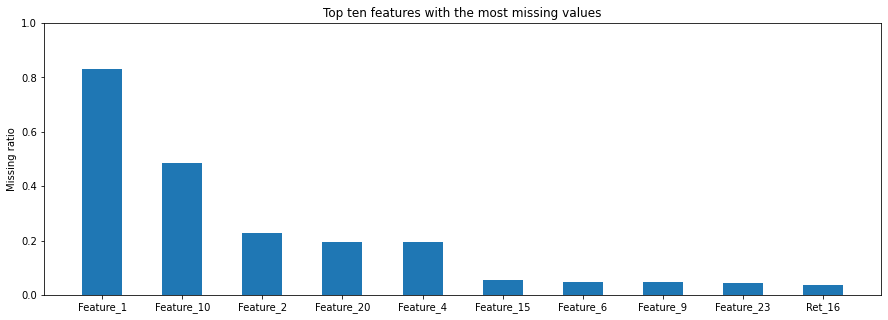

In [3]:
fig, ax = plt.subplots(figsize = (15, 5))
df_na = (df.isnull().sum() / len(df))
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending = False)[: 10]
ax.bar(range(df_na.size), df_na, width = 0.5)
plt.xticks(range(df_na.size), df_na.index, rotation = 0)
plt.ylim([0, 1])
plt.title('Top ten features with the most missing values')
plt.ylabel('Missing ratio')
plt.show()

We separate the time series of the stock returns in every minute from the independent variables. I tried to use the Recurrent Neural Network (RNN) to deal with the time series, but the RNN suffers from overfitting very badly. I finally decide to take the sum of all returns in the time series as a single feature representing the stock return in the first two hours in the current day. 

Similarly, I tried many models to predict the time series of the intra-day stock returns. None of them beat the all-zero prediction. This is reasonable because in real life we only need to predict the stock return in the next minute. We can update our model every minute with new observations. Therefore, I will just use the all-zero prediction for the intra-day stock returns and focus on predicting the stock returns in the two following days.

In [4]:
ret = df.loc[:, 'Ret_2':'Ret_120'].sum(1)
new_ret = new_df.loc[:, 'Ret_2':'Ret_120'].sum(1)

X = np.hstack((df.loc[:, 'Feature_1':'Ret_MinusOne'].values, ret.values[:, np.newaxis]))
ts = df.loc[:, 'Ret_2':'Ret_120'].values
y = df.loc[:, 'Ret_PlusOne':'Ret_PlusTwo'].values
y_ts = df.loc[:, 'Ret_121':'Ret_180'].values

new_X = np.hstack((new_df.loc[:, 'Feature_1':'Ret_MinusOne'].values, new_ret.values[:, np.newaxis]))
new_ts = new_df.loc[:, 'Ret_2':'Ret_120'].values

Since we do not know what those independent variables stand for, we just impute the missing values with the mean of that feature. If we are in a real world knowing the meaning of those independent variables, we may find better imputation methods.

In [5]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(strategy = 'mean')
X = imr.fit_transform(X)
new_X = imr.transform(new_X)

ts = imr.fit_transform(ts)
new_ts = imr.transform(new_ts)

Below are three examples of the time series of the stock returns in the first 120 minutes of the current day. We see that different stock can behaves very different. Detailed analysis of the time series will give us much information on the volatilities of the stocks, which are very useful in pricing options on the stocks.

However, the details of the time series are too noisy to be useful to predict the average stock returns. As I mentioned before, we take the sum of the returns in the time series as a single feature.

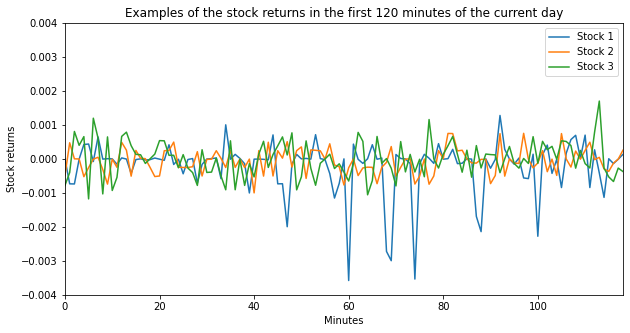

In [6]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(ts[0, :], label = 'Stock 1')
plt.plot(ts[1, :], label = 'Stock 2')
plt.plot(ts[2, :], label = 'Stock 3')
plt.ylim([-0.004, 0.004])
plt.xlim([0, 118])
plt.ylabel('Stock returns')
plt.xlabel('Minutes')
plt.title('Examples of the stock returns in the first 120 minutes of the current day')
plt.legend()
plt.show()

We draw the correlations between different features in the data. Some independent variables are strongly correlated with each other. We will discuss this in the following two cells. We also notice that the target variables are almost not correlated with the independent features. This implies that it is very hard for our model to beat some naive predictions such as the all-zero prediction and the median prediction.

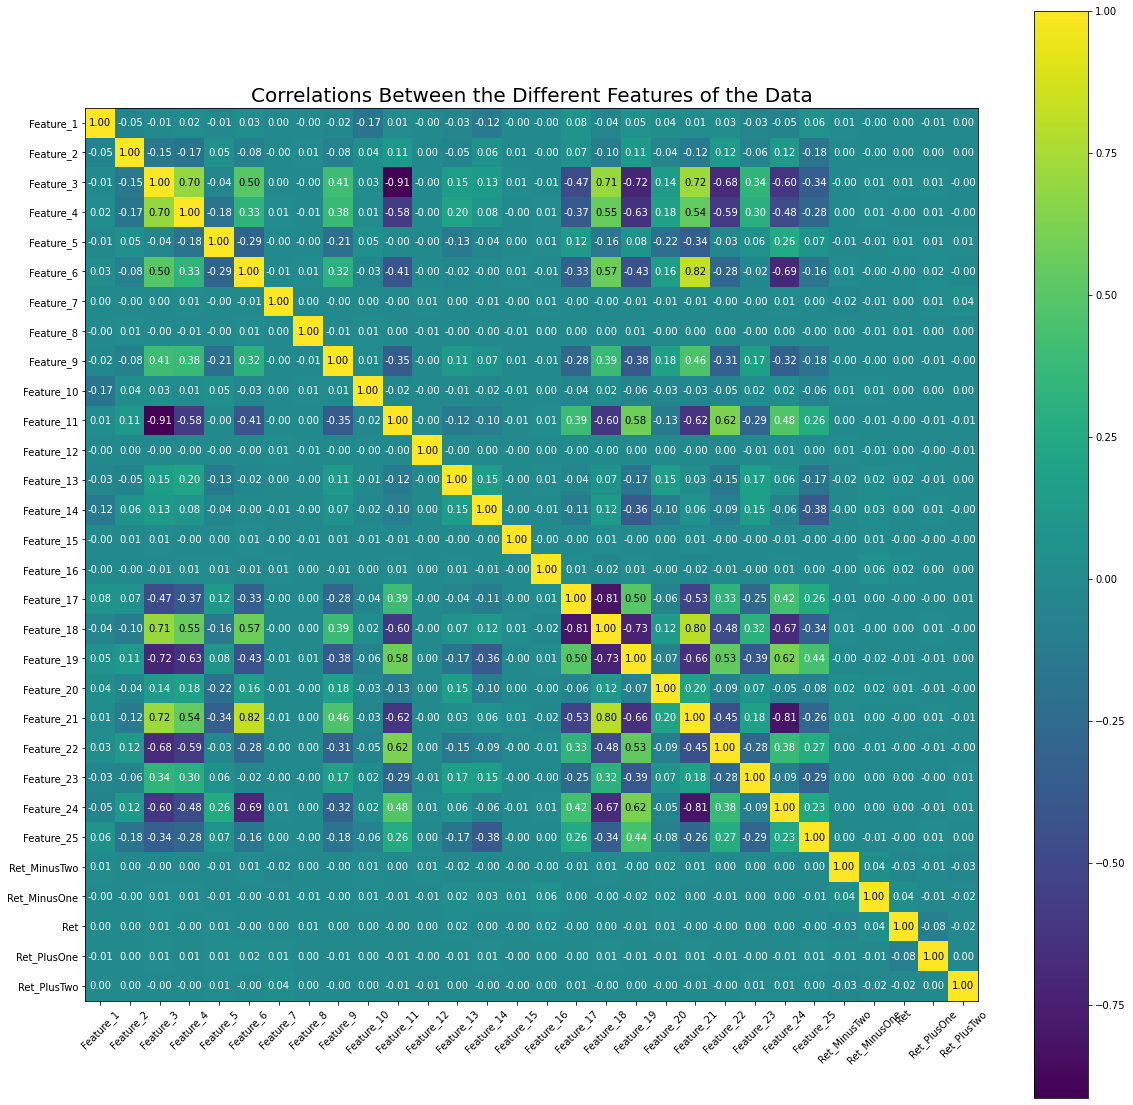

In [7]:
from mlxtend.plotting import heatmap

cm = np.corrcoef(np.hstack([X, y]).T)
cols = list(df.columns[1:28]) + ['Ret', 'Ret_PlusOne', 'Ret_PlusTwo']
hm = heatmap(cm, row_names = cols, column_names = cols, figsize = (20, 20))
plt.title('Correlations Between the Different Features of the Data', fontsize = 20)
plt.show()

Here is an example of a strong correlation between two independent variables.

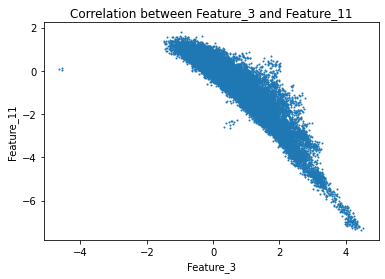

In [8]:
plt.scatter(df['Feature_3'], df['Feature_11'], marker = 'o', s = 1) #, linewidth = 1, edgecolor = 'black')
plt.title('Correlation between Feature_3 and Feature_11')
plt.xlabel('Feature_3')
plt.ylabel('Feature_11')
plt.show()

We can use the Principal Component Analysis (PCA) to decouple those independent variables. Below is an example of using PCA. However, my experience shows that using PCA make our model perform worse here. I think this is because many of the independent variable are not useful in predicting future stock returns. In using PCA, we mix useful independent variables and useless independent variables, which make our model perform worse. Therefore, we will not use PCA here.

In [9]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

#scaler = StandardScaler()
#X[:, :25] = scaler.fit_transform(X[:, :25])
#pca = PCA(n_components = 25)
#X[:, :25] = pca.fit_transform(X[:, :25])

The data are split into training data, validation data, and testing data. From the discuss section of this Challenge, we know the Feature_7 is closely related to the time. Therefore, we do not use cross-validation or random splitting here. Otherwise, future information will leak into the training data, and we will get a model that performs very good on the training data but is not useful in predicting future unseen data.

In [10]:
X_train = X[:30000, :]
X_val = X[30000:35000, :]
X_test = X[35000:, :]
y_train = y[:30000, :]
y_val = y[30000:35000, :]
y_test = y[35000:, :]
X_train_val = X[:35000, :]
y_train_val = y[:35000, :]

The stock returns in the following two days are split to two target variables.

In [11]:
y1_train = y_train[:, 0]
y2_train = y_train[:, 1]
y1_val = y_val[:, 0]
y2_val = y_val[:, 1]
y1_test = y_test[:, 0]
y2_test = y_test[:, 1]
y1_train_val = y_train_val[:, 0]
y2_train_val = y_train_val[:, 1]
y1 = y[:, 0]
y2 = y[:, 1]

# Feature Selection with XGBoost

We use a preliminary XGBoost regressor to do feature selections in this section.

The Numpy ndarray are transformed into a DMatrix to be compatible with the xgboost package.

In [12]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y1_train)

param = { 'verbosity': 0,
          'objective': 'reg:pseudohubererror',
          'eval_metric': 'mae',
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'tree_method': 'gpu_hist',
          'eta': 0.1,
          'max_depth': 5,
          'gamma': 0,
          'min_child_weight': 1 }

bst = xgb.cv(param, dtrain, nfold = 3, num_boost_round = 1000, early_stopping_rounds = 50)

Below is the Mean Absolute Error (MAE) of the training data and validation data during the training.

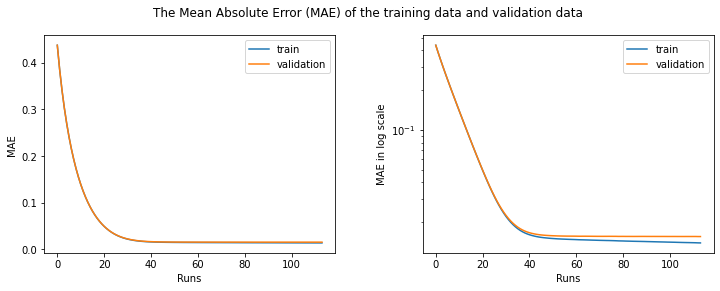

In [13]:
fig = plt.figure(figsize = (12, 4))
fig.suptitle('The Mean Absolute Error (MAE) of the training data and validation data')
plt.subplot(121)
plt.plot(bst['train-mae-mean'], label = 'train')
plt.plot(bst['test-mae-mean'], label = 'validation')
plt.xlabel('Runs')
plt.ylabel('MAE')
plt.legend()
plt.subplot(122)
plt.plot(bst['train-mae-mean'], label = 'train')
plt.plot(bst['test-mae-mean'], label = 'validation')
plt.yscale('log')
plt.xlabel('Runs')
plt.ylabel('MAE in log scale')
plt.legend()
plt.subplots_adjust(wspace = 0.3)
plt.show()

The following figure shows the importance of each independent variable in building the decision trees in the XGBoost regressor. The most important feature 'f6' is the "Feature_7" in the original data. The following three important features 'f25', 'f26', 'f27' are the stock returns in the previous two days and the current day. 

Since the independent variables are almost not correlated with the target variables, including all of them will introduce many noises in our model. We only use the ten most important independent variables in our model.

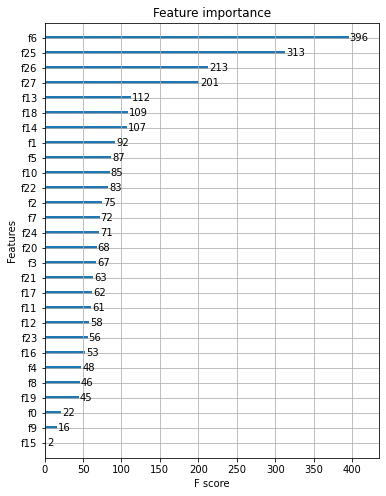

In [14]:
xgb_med = xgb.train(param, dtrain, num_boost_round = bst.shape[0])

fig, ax = plt.subplots(figsize = (6, 8))
xgb.plot_importance(xgb_med, ax = ax)
plt.show()

Here is an example of one decision tree inside the XGBoost model. It has only one leaf.

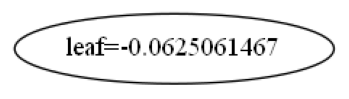

In [15]:
fig, ax = plt.subplots()
xgb.plot_tree(xgb_med, ax = ax)
plt.show()

We select the ten most important independent variables.

In [16]:
select = [1, 5, 6, 13, 14, 18, 22, 25, 26, 27]

X_train = X[:30000, select]
X_val = X[30000:35000, select]
X_test = X[35000:, select]
X_train_val = X[:35000, select]

# Model Training with XGBoost Regressor

We carefully train a XGBoost regressor in this section. Notice that we use Pseudo-Huber loss function which is a differentiable approximation of the linear loss function. It is less sensitive to outliers compared to the conventional square loss function. This is a key idea that make our model perform well.

We first define a utility function to perform grid search for parameter tuning. The utility function can tune parameters on one-dimensional and two-dimensional grids. 

In [17]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def mysearch(X_train, y_train, X_val, y_val, param, param1, param2 = None, estimator = XGBRegressor, score = mean_absolute_error):
    best_score = 10000000.
    best_param = { **param }
    para = { **param }
    key1 = list(param1.keys())[0]
    if param2 is not None:
        key2 = list(param2.keys())[0]
        for parama in param1[key1]:
            for paramb in param2[key2]:
                para[key1] = parama
                para[key2] = paramb
                est = estimator(**para)
                est.fit(X_train, y_train)
                y_pred = est.predict(X_val)
                current_score = score(y_pred, y_val)
                #print('The current score: ', current_score)
                #print('The current parameter: {} = {}, {} = {}'.format(key1, parama, key2, paramb))
                if (current_score < best_score):
                    best_score = current_score
                    best_param[key1] = parama
                    best_param[key2] = paramb
        #print('The best score: ', best_score)
        #print('The best parameter: {} = {}, {} = {}'.format(key1, best_param[key1], key2, best_param[key2]))
    else:
        for parama in param1[key1]:
            para[key1] = parama
            est = estimator(**para)
            est.fit(X_train, y_train)
            y_pred = est.predict(X_val)
            current_score = score(y_pred, y_val)
            print('The current score: ', current_score)
            print('The current parameter: {} = {}'.format(key1, parama))
            if (current_score < best_score):
                best_score = current_score
                best_param[key1] = parama
        #print('The best score: ', best_score)
        #print('The best parameter: {} = {}'.format(key1, best_param[key1]))
    return best_score, best_param

Here is an example of using the utility function to tune the maximum depth of the tree and the minimum child weight. The tuning of other parameters are omitted here for brevity.

In [18]:
param = {'learning_rate': 0.1,
         'verbosity': 0,
         'objective': 'reg:pseudohubererror',
         'tree_method': 'gpu_hist',
         'n_estimators': 100,
         'n_jobs': -1,
         'gamma': 0,
         'subsample': 0.8,
         'colsample_bytree': 0.8,
         'alpha': 0}
param1 = { 'max_depth': [1, 3, 5] }
param2 = { 'min_child_weight': [1, 3, 5] }
score, bst_param = mysearch(X_train, y1_train, X_val, y1_val, param, param1, param2)
print('The best score is:', score)
print('The best parameter is:', bst_param)

The best score is: 0.014936641928747002
The best parameter is: {'learning_rate': 0.1, 'verbosity': 0, 'objective': 'reg:pseudohubererror', 'tree_method': 'gpu_hist', 'n_estimators': 100, 'n_jobs': -1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha': 0, 'max_depth': 5, 'min_child_weight': 5}


Here is the final parameters after all tunings.

In [19]:
best_xgbr = XGBRegressor( objective = 'reg:pseudohubererror',
                          tree_method = 'gpu_hist',
                          max_depth = 5,
                          min_child_weight = 3,
                          gamma = 0,
                          subsample = 0.9,
                          colsample_bytree = 0.9,
                          alpha = 0,
                          learning_rate = 0.01,
                          n_estimators = 700)

The final models are trained on the unions of the training data and the validation data. 

In [20]:
best_xgbr.fit(X_train_val, y1_train_val)
y1_test_pred = best_xgbr.predict(X_test)

best_xgbr.fit(X_train_val, y2_train_val)
y2_test_pred = best_xgbr.predict(X_test)

We evaluate the model performance on the testing data. The final models consistently perform better than the all-zero prediction.

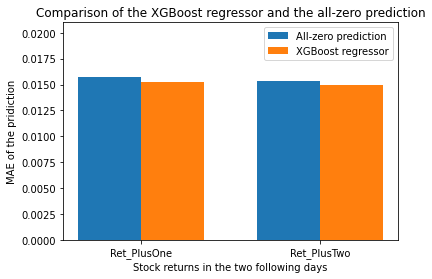

In [21]:
from sklearn.metrics import mean_absolute_error

benchmark = [np.abs(y1_test).mean(), np.abs(y2_test).mean()]
fitted = [mean_absolute_error(y1_test_pred, y_test[:, 0]), mean_absolute_error(y2_test_pred, y_test[:, 1])]

index = np.arange(2)
bar_width = 0.35
plt.bar(index, benchmark, bar_width, label = 'All-zero prediction')
plt.bar(index + bar_width, fitted, bar_width, label = 'XGBoost regressor')
plt.xticks(index + bar_width / 2, ['Ret_PlusOne', 'Ret_PlusTwo'])
plt.title('Comparison of the XGBoost regressor and the all-zero prediction')
plt.xlabel('Stock returns in the two following days')
plt.ylabel('MAE of the pridiction')
plt.ylim([0, 0.021])
plt.legend()
plt.show()

We final train the models on the whole data and make prediction on the unseen data.

In [22]:
best_xgbr.fit(X[:, select], y[:, 0])
y1_new_pred = best_xgbr.predict(new_X[:, select])

best_xgbr.fit(X[:, select], y[:, 1])
y2_new_pred = best_xgbr.predict(new_X[:, select])

Ensembles of the XGBoost regressor and the median prediction are used for the final results. The median prediction are used here to reduce overfitting.

In [23]:
y1_new_pred = 0.1 * y1_new_pred + 0.9 * np.median(y[:, 0])
y2_new_pred = 0.1 * y2_new_pred + 0.9 * np.median(y[:, 1])

ts_new_pred = np.zeros((new_X.shape[0], 60))

# zip_file = ZipFile('../input/the-winton-stock-market-challenge/sample_submission_2.csv.zip')
zip_file = ZipFile('sample_submission_2.csv.zip')
sub = pd.read_csv(zip_file.open('sample_submission_2.csv'))
sub['Predicted'] = np.hstack([ts_new_pred, y1_new_pred[:, np.newaxis], np.median(y[:, 1])* np.ones((new_X.shape[0], 1))]).flatten()
#sub.to_csv('submission.csv', index = False)